In [1]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
#NEW IMPORT
from besos.optimizer import GeneticAlgorithm
from besos.optimizer import platypus_alg
from besos.optimizer import NSGAII
from dask.distributed import Client
import pandas as pd
import numpy as np

In [2]:
client = Client()
client

/home/ict4bd/.local/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45875 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45875/status,
Dashboard: http://127.0.0.1:45875/status,Workers: 2
Total threads: 2,Total memory: 3.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41939,Workers: 2
Dashboard: http://127.0.0.1:45875/status,Total threads: 2
Started: Just now,Total memory: 3.84 GiB
Comm: tcp://10.0.2.15:41697,Total threads: 1
Dashboard: http://10.0.2.15:41139/status,Memory: 1.92 GiB
Nanny: tcp://127.0.0.1:38253,


## IDF Retrieval

IDF files are retrieved from the local folder. The following parameters are used and changed according to the one in analysis:

`glaze_flag` is the flag that indicates wheter the IDF file refers to a single, double or triple glazing model

`ventilation_flag` refers to the ventilation activation

`shading_flag` tells wheter the shading system is active or not. 

In [3]:
glaze_flag = 3 #it has to be in range 1 to 3
ventilation_flag = 1 #0 off, 1 on
shading_flag = 1 #0 off, 1 on

base_path = "/home/ict4bd/idfs/"
epw_filePath = '/home/ict4bd/Torre_Pellice-hour.epw'

if glaze_flag == 1:
    if ventilation_flag == 0 and shading_flag == 0:
        building = ef.get_building(base_path+'idf1_off_off.idf')
    elif ventilation_flag == 1 and shading_flag == 0:
        building = ef.get_building(base_path+'idf1_on_off.idf')
    elif ventilation_flag == 0 and shading_flag == 1:
        building = ef.get_building(base_path+'idf1_off_on.idf')
    elif ventilation_flag == 1 and shading_flag == 1:
        building = ef.get_building(base_path+'idf1_on_on.idf')
elif glaze_flag == 2:
    if ventilation_flag == 0 and shading_flag == 0:
        building = ef.get_building(base_path+'idf2_off_off.idf')
    elif ventilation_flag == 1 and shading_flag == 0:
        building = ef.get_building(base_path+'idf2_on_off.idf')
    elif ventilation_flag == 0 and shading_flag == 1:
        building = ef.get_building(base_path+'idf2_off_on.idf')
    elif ventilation_flag == 1 and shading_flag == 1:
        building = ef.get_building(base_path+'idf2_on_on.idf')
elif glaze_flag == 3:
    if ventilation_flag == 0 and shading_flag == 0:
        building = ef.get_building(base_path+'idf3_off_off.idf')
    elif ventilation_flag == 1 and shading_flag == 0:
        building = ef.get_building(base_path+'idf3_on_off.idf')
    elif ventilation_flag == 0 and shading_flag == 1:
        building = ef.get_building(base_path+'idf3_off_on.idf')
    elif ventilation_flag == 1 and shading_flag == 1:
        building = ef.get_building(base_path+'idf3_on_on.idf')
else:
    print("error, model type not valid")


### Materials and Construction Retrieval
Materials inside the building are then inspected to understand the insulating ones

In [4]:

materials_list = [materials.Name for materials in building.idfobjects["MATERIAL"]]# get a list of the Name property of all IDF objects of class MATERIAL

print(materials_list)

['Plasterboard_.013', 'Cast Concrete (Lightweight)_.1', 'MW Glass Wool (rolls)_.1319', 'Plywood (Heavyweight)_.01', 'External Rendering_.025', 'MW Stone Wool (rolls)_.1482', 'Timber Flooring_.005', 'Brickwork Outer_.1', 'XPS Extruded Polystyrene  - CO2 Blowing_.0795', 'Concrete Block (Medium)_.1', 'Gypsum Plastering_.013', 'Clay Tile (roofing)_.025', 'Roofing Felt_.005', 'Cast Concrete (Dense)_.1', 'Gypsum Plasterboard_.025', 'Brickwork Inner_.75', 'Painted Oak_.035', 'Gypsum Plastering_.025', 'Brickwork Outer_.35', 'Brickwork Outer_.75', 'Brickwork Inner_.1', 'Brickwork Inner_.22', 'Brickwork Inner_1.35', 'Brickwork Inner_.35', 'Brickwork Inner_.42', 'laterocemento_.24', 'Cement/plaster/mortar - cement screed_.05', 'Timber Flooring_.015', "Soda lime glass (including 'float glass')_.02", 'Brickwork Inner_.5', 'Brickwork Inner_1.05']


In [5]:
cons = building.idfobjects["CONSTRUCTION"]
print(cons)


[
Construction,
    LinearBridgingConstruction,    !- Name
    LinearBridgingLayer;      !- Outside Layer
, 
Construction,
    IRTSurface,               !- Name
    IRTMaterial;              !- Outside Layer
, 
Construction,
    Project semi-exposed ceiling_Reversed,    !- Name
    Plasterboard_.013,        !- Outside Layer
    1_RVAL_2,                 !- Layer 2
    Cast Concrete (Lightweight)_.1,    !- Layer 3
    MW Glass Wool (rolls)_.1319,    !- Layer 4
    Plywood (Heavyweight)_.01;    !- Layer 5
, 
Construction,
    Project semi-exposed ceiling_Reversed_Rev,    !- Name
    Plywood (Heavyweight)_.01,    !- Outside Layer
    MW Glass Wool (rolls)_.1319,    !- Layer 2
    Cast Concrete (Lightweight)_.1,    !- Layer 3
    2_RVAL_4,                 !- Layer 4
    Plasterboard_.013;        !- Layer 5
, 
Construction,
    Project external floor,    !- Name
    External Rendering_.025,    !- Outside Layer
    MW Stone Wool (rolls)_.1482,    !- Layer 2
    Timber Flooring_.005;     !- L

In [6]:
#now we want the surfaces and among them all, we need only the exteral and vertical walls
surfaces = building.idfobjects['BUILDINGSURFACE:DETAILED']
print(surfaces)

s_names = [surface.Name for surface in surfaces]

vertical_walls = []
for sf in surfaces:
    if (sf.tilt == 90.0 and sf.Outside_Boundary_Condition == 'Outdoors'):
        vertical_walls.append(sf)



[
BuildingSurface:Detailed,
    Roof:Zone1_Floor_0_0_0,    !- Name
    Floor,                    !- Surface Type
    Project semi-exposed ceiling_Reversed,    !- Construction Name
    Roof:Zone1,               !- Zone Name
    Surface,                  !- Outside Boundary Condition
    MainXfirst:Zone3_Ceiling_1_0_10000,    !- Outside Boundary Condition Object
    NoSun,                    !- Sun Exposure
    NoWind,                   !- Wind Exposure
    0,                        !- View Factor to Ground
    4,                        !- Number of Vertices
    -2.05415136,              !- Vertex 1 Xcoordinate
    18.03994863,              !- Vertex 1 Ycoordinate
    12.6,                     !- Vertex 1 Zcoordinate
    -8.53915136,              !- Vertex 2 Xcoordinate
    18.03994863,              !- Vertex 2 Ycoordinate
    12.6,                     !- Vertex 2 Zcoordinate
    -8.53915136,              !- Vertex 3 Xcoordinate
    25.72994863,              !- Vertex 3 Ycoordinate
    1

In [7]:
con_change=[]
vert_surface_names = []

for sf in vertical_walls: 
    vert_surface_names.append(sf.Construction_Name)
    

for con in cons: #iterate all the constructions and take only those related to the vertical walls
    if con.Name in vert_surface_names:
        con_change.append(con)

print (con_change)

[
Construction,
    Project wall,             !- Name
    Brickwork Outer_.1,       !- Outside Layer
    XPS Extruded Polystyrene  - CO2 Blowing_.0795,    !- Layer 2
    Concrete Block (Medium)_.1,    !- Layer 3
    Gypsum Plastering_.013;    !- Layer 4
, 
Construction,
    external wall 80cm,       !- Name
    Gypsum Plastering_.025,    !- Outside Layer
    Brickwork Outer_.75,      !- Layer 2
    Gypsum Plastering_.025;    !- Layer 3
]


In [8]:
#once we have the construction, we want all it's materials
mat_select = []
#start from two, because the first is the construction name
for mat in con_change:
    mat_select.append(mat.fieldvalues[2:])


mat_change = []
#do a check on the materials to be sure we have all the material of the construction
for mat in materials_list:
    for change in mat_select:
        if mat in change:
            mat_change.append(mat)
        
mat_change=np.unique(mat_change)
print(mat_change)

#from here in eppy the simulation is ran, so probably we are ready to start with besos simulation
#From here we know precisely the stratigraphy of the verical walls, so we can iterate on that list and eventually modify 
#more parameters

['Brickwork Outer_.1' 'Brickwork Outer_.75' 'Concrete Block (Medium)_.1'
 'Gypsum Plastering_.013' 'Gypsum Plastering_.025'
 'XPS Extruded Polystyrene  - CO2 Blowing_.0795']


In [9]:
#Since now we need to perform the energy plus simulation, we skip the following lines and we go directly to the EvaluatorEP
thickvariation = RangeParameter(min_val = 0.01, max_val = 0.35)

#for now we can leave only the XPS, but in future we can analyze also other fields
insulation = FieldSelector(class_name='Material',
                           object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795',
                           field_name='Thickness')

insulation_param = Parameter(selector=insulation,
                             value_descriptor = thickvariation,
                             name='Insulation Thickness')


print(insulation_param)
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795'), value_descriptors=[RangeParameter(min=0.01, max=0.35)])


/usr/local/lib/python3.8/dist-packages/besos-2.1.3-py3.8.egg/besos/parameters.py:424: FutureWarning: Use value_descriptors instead of value_descriptor.
  warnings.warn(


### 1) Case No Ventilation and no Shading Activated

The only parameter is the`insulation_param`, thus meaning only the insulator thickness is changed during this analysis

In [11]:
if ventilation_flag == 0 and shading_flag == 0:
    parameters=[insulation_param]
    problem=EPProblem(parameters, objectives) # problem = parameters + objectives
    samples = sampling.dist_sampler(sampling.full_factorial, problem, num_samples=14)
    # Num samples reduced by 2 by the full factorial sampling(??)    
    print(samples)

### 2) Case Ventilation=On and Shading=Off

The parameters are the`insulation_param` and the `ACH_param`, thus meaning that both of them are going to change according to their possible combinations. The second parameter stands for Air Change per hour and ranges between 0 and 6. 

In [12]:
if ventilation_flag == 1 and shading_flag == 0:

    for natural_ventilation in building.idfobjects["ZoneVentilation:DesignFlowRate"]:
        natural_ventilation.Design_Flow_Rate_Calculation_Method = 'AirChanges/Hour'
        
    #ACH PARAM
    ACH = FieldSelector(class_name='ZoneVentilation:DesignFlowRate', object_name='*', field_name='Air Changes per Hour')
    ACH_interval = RangeParameter(min_val = 0, max_val = 7)
    ACH_param=Parameter(selector=ACH, value_descriptors=ACH_interval, name='ACH')
    
    
    parameters=[insulation_param] + [ACH_param]
    problem=EPProblem(parameters, objectives) # problem = parameters + objectives
    samples = sampling.dist_sampler(sampling.full_factorial, problem, num_samples=14, level = 4)
    samples

### 3) Case Ventilation=Off and Shading=On

The parameters are the`insulation_param`, the `SHADErad_param`, and the `SHADEtemp_param` thus meaning that all of them are going to change according to their possible combinations. The second and third parameters are done to change the shading setpoints both as regards the solar radiation and the temperature outside. 

In [13]:
if ventilation_flag == 0 and shading_flag == 1:
        
    #SHADE PARAMS
    SHADErad = FieldSelector(class_name='WindowShadingControl',object_name='*', field_name='Setpoint 2')
    SHADErad_interval = RangeParameter(min_val = 80, max_val = 301)
    SHADErad_param=Parameter(selector=SHADErad, value_descriptors=SHADErad_interval, name='SHADErad')
    
    SHADEtemp = FieldSelector(class_name='WindowShadingControl',object_name='*', field_name='Setpoint')
    SHADEtemp_interval = RangeParameter(min_val = 22, max_val = 27)
    SHADEtemp_param=Parameter(selector=SHADEtemp, value_descriptors=SHADEtemp_interval, name='SHADEtemp')
    
    parameters=[insulation_param] + [SHADErad_param] + [SHADEtemp_param]
    problem=EPProblem(parameters, objectives) # problem = parameters + objectives
    samples = sampling.dist_sampler(sampling.full_factorial, problem, num_samples=14)
    samples

### 4) Case Ventilation=On and Shading=On

Here all the previously mentioned parameters are used and combined to have a complete comparison. 

In [14]:
if ventilation_flag == 1 and shading_flag == 1:

    for natural_ventilation in building.idfobjects["ZoneVentilation:DesignFlowRate"]:
        natural_ventilation.Design_Flow_Rate_Calculation_Method = 'AirChanges/Hour'
        
    #ACH PARAM
    ACH = FieldSelector(class_name='ZoneVentilation:DesignFlowRate', object_name='*', field_name='Air Changes per Hour')
    ACH_interval = RangeParameter(min_val = 0, max_val = 7)
    ACH_param=Parameter(selector=ACH, value_descriptors=ACH_interval, name='ACH')
    
        
    #SHADE PARAMS
    SHADErad = FieldSelector(class_name='WindowShadingControl',object_name='*', field_name='Setpoint 2')
    SHADErad_interval = RangeParameter(min_val = 80, max_val = 301)
    SHADErad_param=Parameter(selector=SHADErad, value_descriptors=SHADErad_interval, name='SHADErad')
   
    
    SHADEtemp = FieldSelector(class_name='WindowShadingControl',object_name='*', field_name='Setpoint')
    SHADEtemp_interval = RangeParameter(min_val = 22, max_val = 27)
    SHADEtemp_param=Parameter(selector=SHADEtemp, value_descriptors=SHADEtemp_interval, name='SHADEtemp')
    
    
    parameters=[insulation_param] + [ACH_param] + [SHADErad_param] + [SHADEtemp_param]
    problem=EPProblem(
        inputs = parameters,
        outputs = objectives,
        minimize_outputs=[True, True, True]) # problem = parameters + objectives
    #samples = sampling.dist_sampler(sampling.full_factorial, problem, num_samples=100)
    #print(samples)

Total number of samples (81) is smaller  than input (100) to have an even number of factor levels (3) for all parameters.
    Insulation Thickness       ACH    SHADErad  SHADEtemp
0               0.010000  0.000000   80.000000  22.000000
1               0.123333  0.000000   80.000000  22.000000
2               0.236667  0.000000   80.000000  22.000000
3               0.010000  2.333333   80.000000  22.000000
4               0.123333  2.333333   80.000000  22.000000
..                   ...       ...         ...        ...
76              0.123333  2.333333  227.333333  25.333333
77              0.236667  2.333333  227.333333  25.333333
78              0.010000  4.666667  227.333333  25.333333
79              0.123333  4.666667  227.333333  25.333333
80              0.236667  4.666667  227.333333  25.333333

[81 rows x 4 columns]


Test Purposes only, it is useful to set a single set of parameters to check if the output of the filtered idf and the non filtered one are the same

In [14]:
#useful for the idf vs idf_filtered analisis

#samples = pd.DataFrame.from_dict({"0": {'Insulation Thickness':0.35, 'ACH':4, 'SHADErad':200, 'SHADEtemp':24}}, orient="index")
#evaluator = EvaluatorEP(problem, building, out_dir='/home/ictbd/shared/Labs/Models/Exam/Ste/Codes/Besos/outputdir', err_dir='/home/ictbd/shared/Labs/Models/Exam/Ste/Codes/Besos/outputdir',epw_file=epw_filePath)
#outputs = evaluator.df_apply(samples, keep_input=True)
#outputs

### Running the simulation and getting the results

In [15]:
import platypus 
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw_file=epw_filePath)
#algorithm = GeneticAlgorithm(evaluator, evaluations = 20) # population_size = ) #the population size is the number of samples the model has to extract
#outputs = platypus_alg(evaluator, platypus.NSGAII, evaluations = 2)
outputs = NSGAII(evaluator, evaluations = 10, population_size = 256)
#platypus_problem = evaluator.to_platypus()
#algorithm = platypus.NSGAII(problem = platypus_problem)
#outputs = algorithm.run(5)
outputs.to_csv(path_or_buf = "outputs_NSGAII_2glaze.csv")
outputs

/home/ictbd/py3/lib/python3.8/site-packages/besos-2.1.3-py3.8.egg/besos/evaluator.py:672: FutureWarning: epw_file has been deprecated and will be removed in the future. Use epw instead.
  warn(


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:46
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:48
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:49
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:50
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:51
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:52
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:54
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:55
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:56
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:57
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.21 23:58
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:00
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:01
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:02
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:03
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:04
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:05
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:06
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:08
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:09
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:10
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:11
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:12
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:13
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:14
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:15
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:17
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:18
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:19
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:20
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:21
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:22
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:23
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:24
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:26
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:27
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:28
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:29
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:30
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:31
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:32
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:33
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:34
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:36
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:37
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:38
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:39
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:40
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:41
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:42
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:43
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:45
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:46
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:47
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:48
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:49
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:50
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:51
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:52
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:53
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:55
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:56
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:57
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:58
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 00:59
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:00
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:01
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:02
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:03
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:04
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:06
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:07
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:08
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:09
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:10
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:11
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:12
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:13
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 01min  5.10sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:14
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction #

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:16
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:17
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:18
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:19
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:20
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:21
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:22
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:23
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:25
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:26
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:27
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:28
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:29
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:30
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:31
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:32
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:33
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:35
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:36
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:37
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:38
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:39
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:40
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:41
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:42
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:44
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:45
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:46
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:47
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:48
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:49
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:50
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:51
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:53
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:54
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:55
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:56
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:57
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:58
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 01:59
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:00
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:02
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:03
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:04
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:05
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:06
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:07
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:08
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:09
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:10
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:12
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:13
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:14
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:15
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:16
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:17
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:18
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:19
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:21
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:22
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:23
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:24
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:25
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:26
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:27
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:28
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:29
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:31
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:32
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:33
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:34
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:35
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:36
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:37
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:38
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:40
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:41
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:42
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:43
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:44
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:45
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:46
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:47
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:49
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:50
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:51
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:52
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:53
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:54
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:55
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:56
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:58
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 02:59
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:00
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:01
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:02
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:03
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:04
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:05
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:06
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:08
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:09
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:10
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:11
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:12
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:13
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:14
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:15
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:16
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:18
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:19
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:20
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:21
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:22
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:23
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:24
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:25
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:27
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:28
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:29
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:30
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:31
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:32
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:33
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:34
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:36
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:37
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:38
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:39
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:40
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:41
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:42
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:43
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:45
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:46
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:47
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:48
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:49
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:50
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:51
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:52
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:54
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:55
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:56
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:57
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:58
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 03:59
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:00
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:01
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:02
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:04
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:05
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:06
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:07
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:08
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:09
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:10
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:11
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:12
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:14
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:15
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:16
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:17
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:18
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:19
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:20
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:21
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:23
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:24
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:25
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:26
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:27
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:28
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:29
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:30
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:31
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2021.12.22 04:33
Initializing Response Factors
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED", Construction # 3
Calculating CTFs for "PROJECT SEMI-EXPOSED CEILING_REVERSED_REV", Construction # 4
Calculating CTFs for "PROJECT EXTERNAL FLOOR", Construction # 5
Calculating CTFs for "PROJECT WALL", Construction # 7
Calculating CTFs for "PROJECT UNOCCUPIED PITCHED ROOF", Construction # 9
Calculating CTFs for "PROJECT INTERNAL FLOOR", Construction # 11
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PARTITION 80CM", Construction # 13
Calculating CTFs for "PROJECT PARTITION", Construction # 17
Calculating CTFs for "PROJECT PARTITION_REV", Construction # 18
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 19
Calculating CTFs for "EXTERNAL WALL 40CM UNDERWINDOW", Construction # 23
Calculating CTFs for "EXTERNAL WALL 80CM", Construction # 25
Calculating CTFs for "PARTITION 15CM"

EnergyPlus Completed Successfully.


,Insulation Thickness,ACH,SHADErad,SHADEtemp,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,violation,pareto-optimal
0,0.287345,1.843982,157.573538,22.668678,5.696985e+10,1.158198e+11,6.893183e+09,0,True
1,0.204984,0.877601,300.919513,22.963619,5.647948e+10,1.108646e+11,8.463507e+09,0,False
2,0.279744,0.540891,97.217506,22.400320,5.724486e+10,1.048522e+11,9.503546e+09,0,True
3,0.037553,0.559140,211.786552,26.002266,5.526054e+10,1.441270e+11,8.618021e+09,0,False
4,0.034918,3.776585,110.122131,25.857332,5.533016e+10,1.734473e+11,5.473924e+09,0,False
...,...,...,...,...,...,...,...,...,...
251,0.077836,5.311960,170.027512,23.510742,5.631188e+10,1.596095e+11,5.023514e+09,0,False
252,0.253989,1.124199,209.155473,22.309249,5.729135e+10,1.107075e+11,7.992543e+09,0,False
253,0.149764,2.724091,171.995707,22.664549,5.698933e+10,1.307318e+11,6.011200e+09,0,False
254,0.212425,3.200376,143.802013,24.305441,5.581068e+10,1.296787e+11,5.834436e+09,0,False


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


In [15]:
# Load results from previous simulation
outputs = pd.read_csv("outputdir/outputs_NSGAII_3glaze.csv")
outputs

,Unnamed: 0,Insulation Thickness,ACH,SHADErad,SHADEtemp,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,violation,pareto-optimal
0,0,0.154243,4.823947,300.975064,22.125782,8.041368e+10,1.635803e+11,3.612817e+09,0,False
1,1,0.244702,5.069158,227.796881,24.899228,7.926744e+10,1.588063e+11,3.452103e+09,0,False
2,2,0.160759,6.937090,262.629792,23.612847,7.963744e+10,1.710753e+11,3.315791e+09,0,False
3,3,0.047620,5.486296,211.821106,22.800403,8.007876e+10,1.932007e+11,3.665534e+09,0,False
4,4,0.331466,0.630422,201.553487,22.247156,8.040130e+10,1.246123e+11,6.494497e+09,0,False
...,...,...,...,...,...,...,...,...,...,...
251,251,0.173449,6.052542,242.068706,24.545713,7.933624e+10,1.669350e+11,3.361879e+09,0,False
252,252,0.323846,2.771341,117.008583,22.377058,8.036221e+10,1.428331e+11,4.199229e+09,0,False
253,253,0.204962,0.474751,83.462396,25.251570,7.921659e+10,1.278157e+11,6.513651e+09,0,False
254,254,0.136698,4.110493,252.247068,24.467949,7.934866e+10,1.617432e+11,3.691565e+09,0,False


### Objectives Plotting

Text(0, 0.5, 'DistrictCooling:Facility')

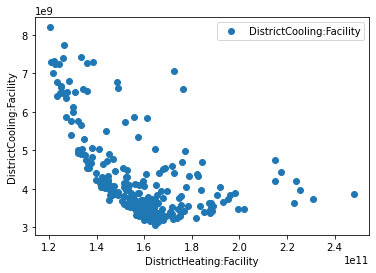

In [16]:
_ = outputs.plot(x=objectives[1], y=objectives[2], style = 'o')
plt.xlabel(objectives[1])
plt.ylabel(objectives[2])

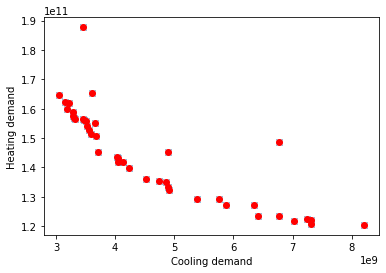

In [17]:
optres = outputs.loc[
    outputs["pareto-optimal"] == True, :
]  # Get only the optimal results
plt.plot(
    optres["DistrictCooling:Facility"], optres["DistrictHeating:Facility"], "x"
)  # Plot all results in the background
plt.plot(
    optres["DistrictCooling:Facility"], optres["DistrictHeating:Facility"], "ro"
)  # Plot optimal results in red
plt.xlabel("Cooling demand")
plt.ylabel("Heating demand");

In [18]:
# Remove columns not used
#outputs= outputs.drop(columns=["violation", "Unnamed: 0"])
optres = optres.drop(columns=["violation", "pareto-optimal", "Unnamed: 0"])

In [19]:
# Round the output and put it in centimeters
optres["Insulation Thickness"] = np.around(optres["Insulation Thickness"] * 100, 3)

In [20]:
# Choose how to sort data
optres = optres.sort_values("DistrictCooling:Facility")
#outputs = outputs.sort_values(by=["Insulation Thickness"])
optres

,Insulation Thickness,ACH,SHADErad,SHADEtemp,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
59,27.286,6.981500,279.836789,26.865723,7.870446e+10,1.646948e+11,3.057052e+09
119,30.372,6.587342,199.272982,26.317380,7.892600e+10,1.624306e+11,3.155079e+09
133,32.868,6.074510,212.356812,26.463311,7.887527e+10,1.599678e+11,3.190140e+09
65,23.622,5.784287,154.572778,26.727468,7.877987e+10,1.620918e+11,3.214963e+09
30,34.264,5.835497,111.004010,25.757234,7.909516e+10,1.587710e+11,3.279170e+09
92,33.864,5.515744,260.207440,26.057058,7.898369e+10,1.576612e+11,3.289717e+09
93,31.234,5.178734,176.195156,26.490203,7.887173e+10,1.569474e+11,3.310714e+09
160,28.938,4.936433,251.317271,26.833997,7.874263e+10,1.565450e+11,3.318384e+09
250,5.318,5.021466,148.100087,26.984614,7.867065e+10,1.877508e+11,3.451037e+09
87,33.646,5.204999,109.235784,24.047005,7.947831e+10,1.564479e+11,3.460390e+09


### Barplots Results vs Parameters

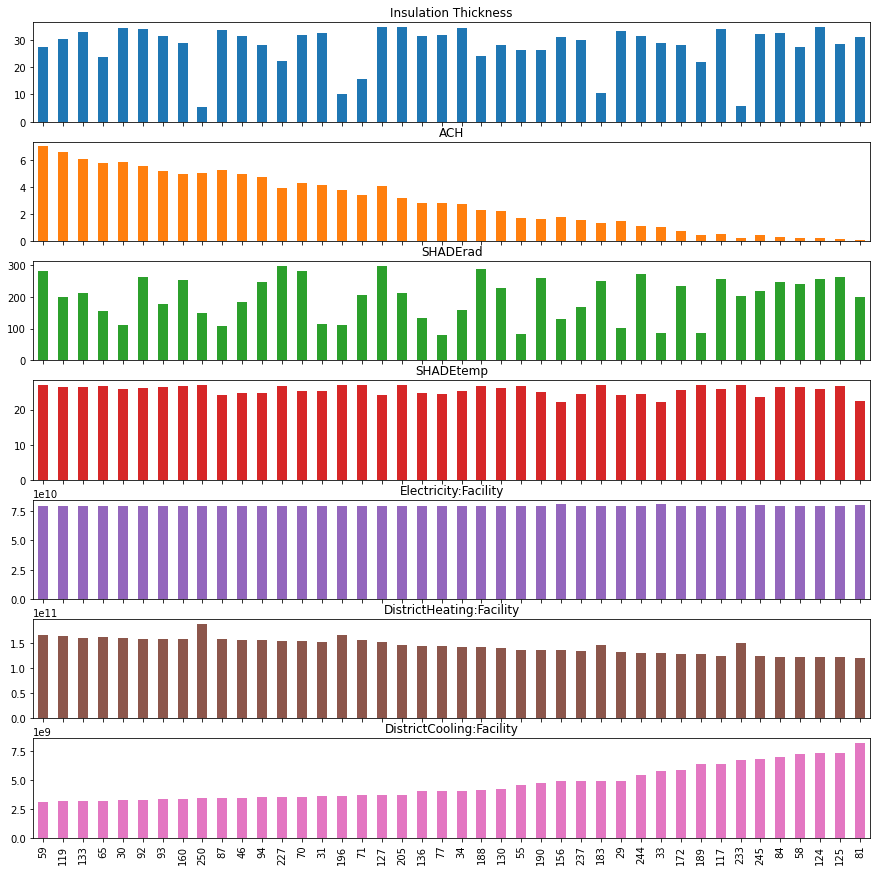

In [22]:
ax=optres.plot.bar(subplots=True,legend=None, figsize=(15,15))

## Visualising the parametric analysis

A better way to analyse the results is by looking at scatter plots of the inputs versus the outputs.  
This enables us to visually see strong relationships of inputs and outputs.

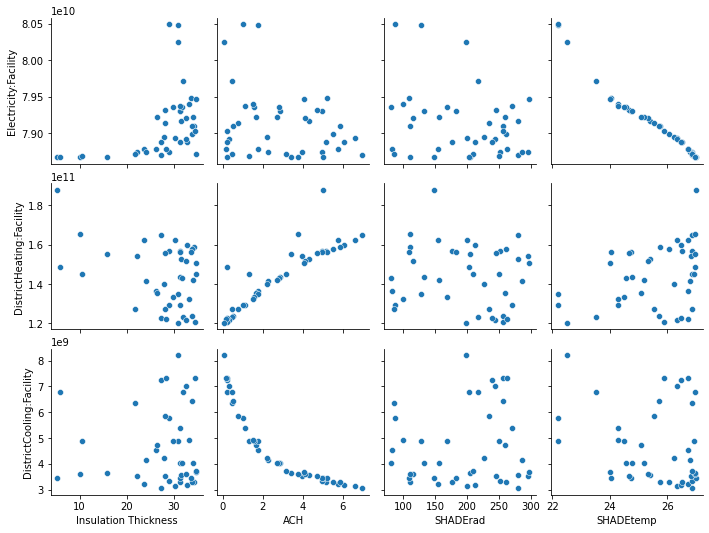

In [24]:
_=pairplot(optres,x_vars=samples.columns, y_vars=objectives, kind="scatter")
#_=pairplot(outputs,x_vars=[outputs["Insulation Thickness"], outputs["ACH"], outputs["SHADErad"], outputs["SHADEtemp"]], y_vars=objectives, kind="scatter")

### Correlation Heatmap
Allowed only if more parameters are used, flags are controlled. 

In [25]:
optres.corr()

,Insulation Thickness,ACH,SHADErad,SHADEtemp,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Insulation Thickness,1.000000,0.062804,0.048600,-0.468586,0.435817,-0.356883,0.002978
ACH,0.062804,1.000000,-0.031137,0.237836,-0.252280,0.887368,-0.899021
SHADErad,0.048600,-0.031137,1.000000,0.246604,-0.266950,-0.087558,0.108470
SHADEtemp,-0.468586,0.237836,0.246604,1.000000,-0.980705,0.370497,-0.226323
Electricity:Facility,0.435817,-0.252280,-0.266950,-0.980705,1.000000,-0.380900,0.258633
DistrictHeating:Facility,-0.356883,0.887368,-0.087558,0.370497,-0.380900,1.000000,-0.851799
DistrictCooling:Facility,0.002978,-0.899021,0.108470,-0.226323,0.258633,-0.851799,1.000000


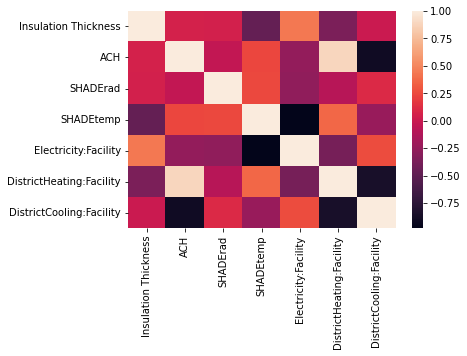

In [26]:
    _ = heatmap(optres.corr())

## Find the optimal set of parameters from the result

In [28]:
# Add a total consumption column
optres["TotConsumption"] = optres["DistrictHeating:Facility"] + optres["DistrictCooling:Facility"] + optres["Electricity:Facility"]
optres

,Insulation Thickness,ACH,SHADErad,SHADEtemp,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,TotConsumption
59,27.286,6.981500,279.836789,26.865723,7.870446e+10,1.646948e+11,3.057052e+09,2.464563e+11
119,30.372,6.587342,199.272982,26.317380,7.892600e+10,1.624306e+11,3.155079e+09,2.445117e+11
133,32.868,6.074510,212.356812,26.463311,7.887527e+10,1.599678e+11,3.190140e+09,2.420333e+11
65,23.622,5.784287,154.572778,26.727468,7.877987e+10,1.620918e+11,3.214963e+09,2.440866e+11
30,34.264,5.835497,111.004010,25.757234,7.909516e+10,1.587710e+11,3.279170e+09,2.411453e+11
92,33.864,5.515744,260.207440,26.057058,7.898369e+10,1.576612e+11,3.289717e+09,2.399346e+11
93,31.234,5.178734,176.195156,26.490203,7.887173e+10,1.569474e+11,3.310714e+09,2.391299e+11
160,28.938,4.936433,251.317271,26.833997,7.874263e+10,1.565450e+11,3.318384e+09,2.386060e+11
250,5.318,5.021466,148.100087,26.984614,7.867065e+10,1.877508e+11,3.451037e+09,2.698725e+11
87,33.646,5.204999,109.235784,24.047005,7.947831e+10,1.564479e+11,3.460390e+09,2.393866e+11


In [29]:
# Find the best parameters, i.e. those that allow the lowest consumption
bestParams = optres[optres.TotConsumption == optres.TotConsumption.min()]
bestParams.to_csv("OptimizationResults/1SingleGlazing/bestParams.csv")
bestParams

,Insulation Thickness,ACH,SHADErad,SHADEtemp,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,TotConsumption
124,34.539,0.203801,255.746361,25.870746,7.902698e+10,1.206856e+11,7.308874e+09,2.070214e+11


In [84]:
# To access directly the parameters
optACH = bestParams.iloc[0]["ACH"]
optACH

0.2038012150328801

Put the results of the three glazings all together so that comparsions can be made

In [129]:
singleBestParams = pd.read_csv("OptimizationResults/1SingleGlazing/bestParams.csv")
doubleBestParams = pd.read_csv("OptimizationResults/2DoubleGlazing/bestParams.csv")
tripleBestParams = pd.read_csv("OptimizationResults/3TripleGlazing/bestParams.csv")

   Unnamed: 0  Insulation Thickness       ACH    SHADErad  SHADEtemp  \
0         217                28.943  0.086745  124.391787  26.596226   

   Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  \
0          5.498551e+10              1.008395e+11              1.196473e+10   

   TotConsumption  
0    1.677897e+11  


In [160]:
totBestParams = pd.concat([singleBestParams, doubleBestParams, tripleleBestParams], ignore_index=True)
#totBestParams.loc[0, "Unnamed: 0"] = 1
totBestParams = totBestParams.drop(columns = "Unnamed: 0") 
totBestParams.loc[0, "Glazing"] = 1 
totBestParams.loc[1, "Glazing"] = 2
totBestParams.loc[2, "Glazing"] = 3
totBestParams.insert(0, "Glazing", totBestParams.pop("Glazing"))
totBestParams.to_csv("OptimizationResults/totBestParams.csv")
totBestParams

,Glazing,Insulation Thickness,ACH,SHADErad,SHADEtemp,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,TotConsumption
0,1.0,35.876,0.208331,149.964839,23.972565,5.450089e+10,1.094539e+11,1.197247e+10,1.759272e+11
1,2.0,28.943,0.086745,124.391787,26.596226,5.498551e+10,1.008395e+11,1.196473e+10,1.677897e+11
2,3.0,34.539,0.203801,255.746361,25.870746,7.902698e+10,1.206856e+11,7.308874e+09,2.070214e+11
